In [1]:
# Importing
import theano.tensor as T
import sys, os
sys.path.append("../GeMpy")
sys.path.append("../pygeomod")

import GeMpy_core
import Visualization

import importlib
importlib.reload(GeMpy_core)
importlib.reload(Visualization)
import numpy as np
import pandas as pn
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
np.set_printoptions(precision = 6, linewidth= 130, suppress =  True)

%matplotlib inline
#%matplotlib notebook

Using gpu device 0: GeForce GTX 970 (CNMeM is disabled, cuDNN not available)


# Sandstone Model

First we make a GeMpy instance with most of the parameters default (except range that is given by the project). Then we also fix the extension and the resolution of the domain we want to interpolate. Finally we compile the function, only needed once every time we open the project (the guys of theano they are working on letting loading compiled files, even though in our case it is not a big deal).

*General note. So far the reescaling factor is calculated for all series at the same time. GeoModeller does it individually for every potential field. I have to look better what this parameter exactly means*

In [16]:
# Setting extend, grid and compile
# Setting the extent
sandstone = GeMpy_core.GeMpy()

# Create Data class with raw data
sandstone.import_data( 696000,747000,6863000,6950000,-20000, 2000, 40, 40, 80,
                                     path_f = os.pardir+"/input_data/a_Foliations.csv",
                                     path_i = os.pardir+"/input_data/a_Points.csv")

sandstone.Data.set_series({"EarlyGranite_Series":sandstone.Data.formations[-1], 
                      "BIF_Series":(sandstone.Data.formations[0], sandstone.Data.formations[1]),
                      "SimpleMafic_Series":sandstone.Data.formations[2]}, 
                       order = ["EarlyGranite_Series",
                              "BIF_Series",
                              "SimpleMafic_Series"]) 

,EarlyGranite_Series,BIF_Series,SimpleMafic_Series
0,EarlyGranite,SimpleMafic2,SimpleMafic1
1,EarlyGranite,SimpleBIF,SimpleMafic1


In [22]:
type(sandstone.Data.formations)

numpy.ndarray

All input data is stored in pandas dataframes under, ```self.Data.Interances``` and ```self.Data.Foliations```:

In [3]:
sandstone.Data.Foliations;

In [4]:
# Create a class Grid so far just regular grid
sandstone.create_grid()
sandstone.Grid.grid

array([[  696000.      ,  6863000.      ,   -20000.      ],
       [  696000.      ,  6863000.      ,   -19721.519531],
       [  696000.      ,  6863000.      ,   -19443.037109],
       ..., 
       [  747000.      ,  6950000.      ,     1443.037964],
       [  747000.      ,  6950000.      ,     1721.519043],
       [  747000.      ,  6950000.      ,     2000.      ]], dtype=float32)

## Plotting raw data

/home/miguel/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['Times New Roman'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


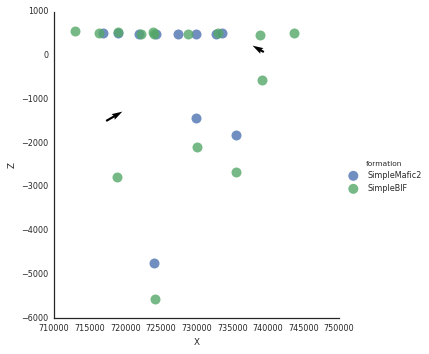

In [5]:
sandstone.Plot.plot_data(serie = sandstone.Data.series.columns.values[1])

## Class Interpolator

This class will take the data from the class Data and calculate potential fields and block

In [6]:
sandstone.set_interpolator(range_var = 110000)

##  Early granite

/home/miguel/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['Times New Roman'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


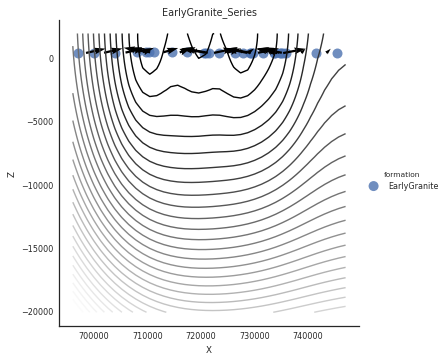

In [7]:
sandstone.Plot.plot_potential_field(10, n_pf=0)

## BIF Series

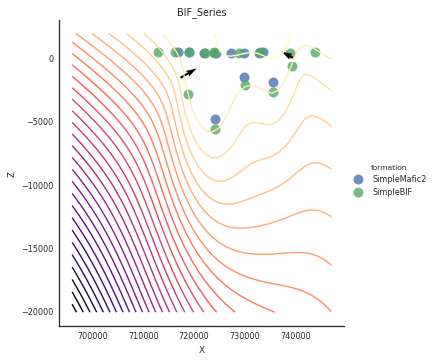

In [8]:
sandstone.Plot.plot_potential_field(13, n_pf=1, cmap = "magma",  plot_data = True,
                                        verbose = 5 )

In [9]:
sandstone.Interpolator.a_T.get_value()

array(103218.21544669333)

In [10]:
sandstone.Interpolator.rescaling_factor_T.get_value()

array(48561.5)

##  SImple mafic

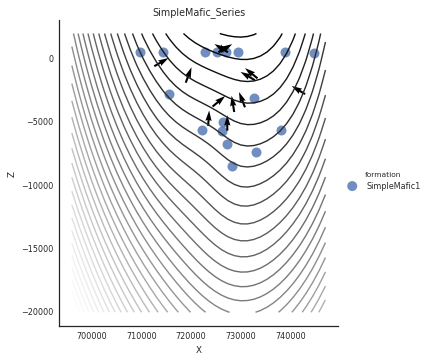

In [11]:
sandstone.Plot.plot_potential_field(10, n_pf=2)

# Optimizing the export of lithologies

Here I am going to try to return from the theano interpolate function the internal type of the result (in this case DK I guess) so I can make another function in python I guess to decide which potential field I calculate at every grid_pos 

In [12]:
# Reset the block
sandstone.Interpolator.block.set_value(np.zeros_like(sandstone.Grid.grid[:,0]))

# Compute the block
sandstone.Interpolator.compute_block_model([0,1,2], verbose = 4)

4
[1 1 1 ..., 1 1 1] 0
The serie formations are EarlyGranite
The formations are: 
Layers               X          Y           Z     formation               series
43  745312.750  6878221.0  452.733051  EarlyGranite  EarlyGranite_Series
44  741494.625  6877535.5  460.202350  EarlyGranite  EarlyGranite_Series
45  735914.188  6876556.5  456.482389  EarlyGranite  EarlyGranite_Series
46  734739.375  6874011.0  446.031913  EarlyGranite  EarlyGranite_Series
47  733564.563  6874598.5  452.620638  EarlyGranite  EarlyGranite_Series
48  734837.313  6876850.5  469.895650  EarlyGranite  EarlyGranite_Series
49  735326.813  6881354.0  492.347775  EarlyGranite  EarlyGranite_Series
50  733858.313  6882724.5  486.360734  EarlyGranite  EarlyGranite_Series
51  731508.625  6881941.0  476.162317  EarlyGranite  EarlyGranite_Series
52  729746.438  6879004.0  468.440123  EarlyGranite  EarlyGranite_Series
53  727788.375  6878514.5  465.162276  EarlyGranite  EarlyGranite_Series
54  729354.813  6881354.0  469.466

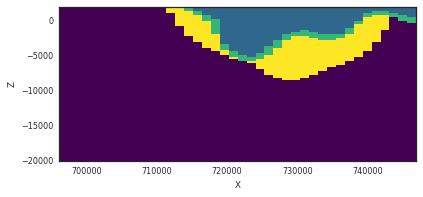

In [13]:
sandstone.Plot.plot_block_section(13, direction='y')

# Export vtk

In [14]:
"""Export model to VTK

Export the geology blocks to VTK for visualisation of the entire 3-D model in an
external VTK viewer, e.g. Paraview.

..Note:: Requires pyevtk, available for free on: https://github.com/firedrakeproject/firedrake/tree/master/python/evtk

**Optional keywords**:
    - *vtk_filename* = string : filename of VTK file (default: output_name)
    - *data* = np.array : data array to export to VKT (default: entire block model)
"""
vtk_filename = "noddyFunct2"

extent_x = 10
extent_y = 10
extent_z = 10

delx = 0.2
dely = 0.2
delz = 0.2
from pyevtk.hl import gridToVTK
# Coordinates
x = np.arange(0, extent_x + 0.1*delx, delx, dtype='float64')
y = np.arange(0, extent_y + 0.1*dely, dely, dtype='float64')
z = np.arange(0, extent_z + 0.1*delz, delz, dtype='float64')

# self.block = np.swapaxes(self.block, 0, 2)
gridToVTK(vtk_filename, x, y, z, cellData = {"geology" : sol})

ImportError: No module named 'pyevtk'

# Performance Analysis

## CPU

In [ ]:
%%timeit
sol =  interpolator.geoMigueller(dips,dips_angles,azimuths,polarity, rest, ref)[0]

In [ ]:
sandstone.block_export.profile.summary()

## GPU

In [ ]:
%%timeit
# Reset the block
sandstone.block.set_value(np.zeros_like(sandstone.grid[:,0]))

# Compute the block
sandstone.compute_block_model([0,1,2], verbose = 0)

In [ ]:
sandstone.block_export.profile.summary()